<a href="https://colab.research.google.com/github/restrepo/articles_COVID-19/blob/master/lens_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lens API search for Coronavirus in Lens

Check: https://docs.api.lens.org/request.html

Get token: https://www.lens.org/lens/user/subscriptions

Examples: https://github.com/cambialens/lens-api-doc

## Functions and global variables

In [1]:
import getpass
import pandas as pd
import requests
import sys
import time
import os
import datetime
if os.getcwd()=='/content':
    !pip install unidecode
    !mkdir data
import unidecode    

mkdir: cannot create directory ‘data’: File exists


<!-- #mmkP9Ibp7bDpLNLKZF8bdYDxCQmxXhFuJzJViVKH92kyBlGmatE2
 -->

In [3]:
token=getpass.getpass('token:')

token:··········


In [0]:
url = 'https://api.lens.org/scholarly/search'
size=1000

In [0]:
def query(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
      title="covid-19" #(or Affiliation o lens_id, or ...)
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    q=unidecode.unidecode(kwargs[key])
    #Set default values
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "match_phrase":{
                    "%s": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(key,q,kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data

def get_query(**kwargs):
    '''
    Use the lens.org API to obtain a DataFrame with the query

    Parameters
    ----------
      title="covid-19" #(or Affiliation o lens_id, or ...)
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
      url=API_url,
      token=token #API token  
    '''
    token=kwargs.get('token')
    url=kwargs.get('url')
    kk=kwargs.pop('url')
    kk=kwargs.pop('token')
    data=query(**kwargs)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    return pd.read_json(r)    

def query_title(title="Dark Matter",range_type="date_published",
          date_ini="1900-01-01",
          date_end="2004-12-31",size=1000):
    """
    WARNING: Accents needs to be removed!
    """
    title=unidecode.unidecode(title)
    if range_type=="year_published":
        date_ini=date_ini.split('-')[0]
        date_end=date_end.split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "match_phrase":{
                    "title": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(title,range_type,date_ini,date_end,size)
    return data

In [6]:
RELOAD=False
rr=pd.DataFrame()
start_date=datetime.datetime.strptime('1900-01-01','%Y-%m-%d')
today=datetime.datetime.today()
for d in ['2020-03-05','2020-03-18',today.strftime('%Y-%m-%d')]:
    if not RELOAD:
        break
    next_date=datetime.datetime.strptime(d,'%Y-%m-%d')
    if next_date.date()==today.date():
        rr.to_json('data/covid_19_{}.json.gz'.format(
             (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')   ))

    print('{} → {} : '.format( start_date.strftime('%Y-%m-%d'),
                              next_date.strftime('%Y-%m-%d') ),
          end='')
    tmp=get_query(title="covid-19",
      range_type="date_published",
      date_ini=start_date.strftime('%Y-%m-%d'),
      date_end=next_date.strftime('%Y-%m-%d'),
      size=1000,
      url=url,
      token=token) 

    print(tmp.shape)
    rr=rr.append( tmp  ).reset_index(drop=True)
    start_date=next_date+datetime.timedelta(days=1)

    time.sleep(5)

1900-01-01 → 2020-03-05 : (944, 3)
2020-03-06 → 2020-03-18 : (988, 3)
2020-03-19 → 2020-04-05 : (991, 3)


### Check results

In [0]:
if RELOAD:
    cv=pd.DataFrame(list(rr.data.values))
    cv.to_json('data/covid_19.json.gz')
else:
    urljason='https://github.com/restrepo/lensapi/raw/master/data/covid_19.json.gz'
    cv=pd.read_json(urljason,compression='gzip')

In [8]:
cv.shape

(2923, 29)

In [0]:
cv.to_json('data/covid_19.json.gz')


In [10]:
cv.scholarly_citations_count.sum()

732.0

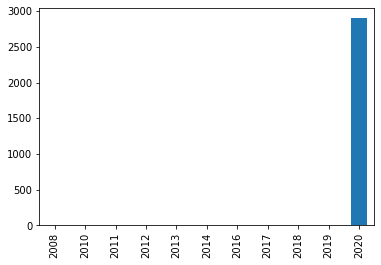

In [11]:
cv['Year']=cv.date_published.apply(lambda s: s.split('-')[0] if type(s)==str else 
                                          s.get('date').split('-')[0] )
cv=cv[~cv['Year'].isna()].reset_index(drop=True)
cv['Year']=cv['Year'].astype(int)
cv[cv['Year']>2007]['Year'].value_counts().sort_index().plot(kind='bar')

### Search for citations

In [27]:
if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
cvc=pd.DataFrame()
i=0
for l in cv['scholarly_citations'].apply(pd.Series).stack().unique():
    i+=1    
    print(i,l)
    tmp=get_query(lens_id=l,url=url,token=token)
    cvc=cvc.append(tmp).reset_index(drop=True)
    cvc.to_json('covid_19_scholarly_citations.json')
    if os.getcwd()=='/content':
        !cp covid_19_scholarly_citations.json drive/My\ Drive
        
    time.sleep(5)

1 031-883-225-563-477
2 041-669-833-363-319
3 003-127-464-982-370
4 014-541-219-035-444
5 015-517-208-703-589
6 019-239-691-300-250
7 035-699-637-023-712
8 075-212-637-705-194
9 077-581-296-242-529
10 082-834-566-213-087
11 131-036-518-863-906
12 143-440-718-134-599
13 176-188-593-862-175
14 182-300-970-351-296
15 012-011-397-538-967
16 018-684-021-973-690
17 182-257-306-271-027
18 077-798-648-024-232
19 066-883-940-279-088
20 049-393-163-370-937
21 050-622-848-394-888
22 051-131-838-590-455
23 062-773-505-695-391
24 113-694-184-552-930
25 088-204-360-607-672
26 030-892-203-652-944
27 084-755-740-368-445
28 131-225-194-423-738
29 039-203-752-503-619
30 042-980-441-830-510
31 109-337-999-920-44X
32 126-880-477-423-009
33 008-543-552-307-644
34 050-268-780-774-083
35 066-410-139-266-468
36 122-601-290-944-891
37 010-093-802-970-403
38 022-670-118-873-087
39 095-661-491-185-542
40 103-917-979-859-840
41 137-402-603-626-476
42 064-823-637-296-857
43 076-028-316-200-837
44 150-190-792-087-8

In [22]:
cvc

,total,data,results
0,1,"{'lens_id': '031-883-225-563-477', 'created': ...",1
1,1,"{'lens_id': '041-669-833-363-319', 'created': ...",1
2,1,"{'lens_id': '003-127-464-982-370', 'created': ...",1
3,1,"{'lens_id': '014-541-219-035-444', 'created': ...",1
4,1,"{'lens_id': '015-517-208-703-589', 'created': ...",1
5,1,"{'lens_id': '019-239-691-300-250', 'created': ...",1
6,1,"{'lens_id': '035-699-637-023-712', 'created': ...",1


In [114]:
get_query(lens_id='031-883-225-563-477',url=url,token=token)

,total,data,results
0,1,"{'lens_id': '031-883-225-563-477', 'created': ...",1


In [24]:
cv.columns

Index(['lens_id', 'created', 'publication_type', 'authors', 'title',
       'languages', 'references', 'fields_of_study', 'source_urls', 'abstract',
       'year_published', 'references_count', 'external_ids', 'source',
       'author_count', 'date_published', 'volume', 'issue', 'mesh_terms',
       'scholarly_citations_count', 'start_page', 'end_page',
       'scholarly_citations', 'funding', 'publication_supplementary_type',
       'open_access', 'keywords', 'chemicals', 'clinical_trials', 'Year'],
      dtype='object')